In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import argparse
import os
import torch
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse import csgraph
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.linalg import fractional_matrix_power as mat_pwr
import scipy.sparse
import time
import random
import os
import sys

import time
from collections import Counter

import random
import os
import sys
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
import networkx as nx

In [2]:


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True, init='xavier'):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        if init == 'uniform':
            print("| Uniform Initialization")
            self.reset_parameters_uniform()
        elif init == 'xavier':
            print("| Xavier Initialization")
            self.reset_parameters_xavier()
        elif init == 'kaiming':
            print("| Kaiming Initialization")
            self.reset_parameters_kaiming()
        else:
            raise NotImplementedError

    def reset_parameters_uniform(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def reset_parameters_xavier(self):
        nn.init.xavier_normal_(self.weight.data, gain=0.02) # Implement Xavier Uniform
        if self.bias is not None:
            nn.init.constant_(self.bias.data, 0.0)

    def reset_parameters_kaiming(self):
        nn.init.kaiming_normal_(self.weight.data, a=0, mode='fan_in')
        if self.bias is not None:
            nn.init.constant_(self.bias.data, 0.0)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [3]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, init):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid, init=init)
        self.gc2 = GraphConvolution(nhid, nclass, init=init)
        self.dropout = dropout

    def bottleneck(self, path1, path2, path3, adj, in_x):
        return F.relu(path3(F.relu(path2(F.relu(path1(in_x, adj)), adj)), adj))

    def forward(self, x, adj):
        x1 = F.dropout(F.relu(self.gc1(x, adj)), self.dropout, training=self.training)
        x2 = self.gc2(x1, adj)

        return x2,F.log_softmax(x2, dim=1)

In [4]:
class BaseOptions():
    def __init__(self):
        self.parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
        self.initialized = False

    def initialize(self):
        pass

    def parse(self):
        if not self.initialized:
            self.initialize()

        self.opt = self.parser.parse_args()
        self.opt.isTrain = self.isTrain
        args = vars(self.opt)

        return self.opt

class TrainOptions():
    # Override
    def __init__(self):
        self.dataroot='data/pubmed'
        self.dataset='pubmed'
        self.num_hidden=32
        self.dropout=0.5
        self.weight_decay=5e-4
        self.init_type='uniform'
        self.model='basic'
        self.lr=5e-3
        self.optimizer='adam'
        self.epoch=200
        self.lr_decay_epoch=5000
#         self.nb_heads=8
#         self.alpha=0.2
        self.isTrain=True

class TestOptions(BaseOptions):
    def initialize(self):
        BaseOptions.initialize(self)
        self.isTrain = False


In [5]:
def parse_index_file(filename):
    index = []

    for line in open(filename):
        index.append(int(line.strip()))

    return index

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)

    return mx

def normalize_adj(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv_sqrt = np.power(rowsum, -0.5).flatten()
    r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt)

    return mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt).tocoo()

def laplacian(mx, norm):
    """Laplacian-normalize sparse matrix"""
    assert (all (len(row) == len(mx) for row in mx)), "Input should be a square matrix"

    return csgraph.laplacian(adj, normed = norm)

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

def load_data(path="/home/bumsoo/Data/Planetoid", dataset="cora"):
    """
    ind.[:dataset].x     => the feature vectors of the training instances (scipy.sparse.csr.csr_matrix)
    ind.[:dataset].y     => the one-hot labels of the labeled training instances (numpy.ndarray)
    ind.[:dataset].allx  => the feature vectors of both labeled and unlabeled training instances (csr_matrix)
    ind.[:dataset].ally  => the labels for instances in ind.dataset_str.allx (numpy.ndarray)
    ind.[:dataset].graph => the dict in the format {index: [index of neighbor nodes]} (collections.defaultdict)

    ind.[:dataset].tx => the feature vectors of the test instances (scipy.sparse.csr.csr_matrix)
    ind.[:dataset].ty => the one-hot labels of the test instances (numpy.ndarray)

    ind.[:dataset].test.index => indices of test instances in graph, for the inductive setting
    """
    print("\n[STEP 1]: Upload {} dataset.".format(dataset))

    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []

    for i in range(len(names)):
        with open("{}/ind.{}.{}".format(path, dataset, names[i]), 'rb') as f:
            objects.append(pkl.load(f,encoding='latin1'))

    x, y, tx, ty, allx, ally, graph = tuple(objects)

    test_idx_reorder = parse_index_file("{}/ind.{}.test.index".format(path, dataset))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset == 'citeseer':
        #Citeseer dataset contains some isolated nodes in the graph
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended

        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]

    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
    print("| # of nodes : {}".format(adj.shape[0]))
    print("| # of edges : {}".format(adj.sum().sum()/2))

    features = normalize(features)
    adj = normalize_adj(adj + sp.eye(adj.shape[0]))
    adj_origin=adj
    
    adj=adj+sp.identity(adj.shape[0])
#     if dataset == 'cora':
#     D=sp.csr_matrix.sum(adj,axis=-1)
# ##    print("Shape of D=",D.shape)
#     D=np.reshape(D,(D.shape[0],))
#     D=np.diagflat(D)
# #    print("D MAtrix is:",D)
# #    print("Weight MAtrix is:",adj)
#     D_sps = sp.coo_matrix(D)
# #    adj_tilde=sp.csr_matrix(mat_pwr(D,-0.5)).multiply(sp.csr_matrix(adj))
#     adj_tilde=sp.csr_matrix(mat_pwr(D,-0.5)).dot(sp.csr_matrix(adj))
#     adj_tilde=sp.csr_matrix(adj_tilde).dot(sp.csr_matrix(mat_pwr(D,-0.5)))
#     adj=adj_tilde
    
    print("| # of features : {}".format(features.shape[1]))
    print("| # of clases   : {}".format(ally.shape[1]))

    features = torch.FloatTensor(np.array(features.todense()))
    sparse_mx = adj.tocoo().astype(np.float32)
    adj = torch.FloatTensor(np.array(adj.todense()))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    if dataset == 'citeseer':
        save_label = np.where(labels)[1]
    labels = torch.LongTensor(np.where(labels)[1])

#    idx_train = range(len(y))
    idx_train = range(1)
    idx_val = range(1, 500)
    idx_test = test_idx_range.tolist()

    print("| # of train set : {}".format(len(idx_train)))
    print("| # of val set   : {}".format(len(idx_val)))
    print("| # of test set  : {}".format(len(idx_test)))

    idx_train, idx_val, idx_test = list(map(lambda x: torch.LongTensor(x), [idx_train, idx_val, idx_test]))

    def missing_elements(L):
        start, end = L[0], L[-1]
        return sorted(set(range(start, end+1)).difference(L))

    if dataset == 'citeseer':
        L = np.sort(idx_test)
        missing = missing_elements(L)

        for element in missing:
            save_label = np.insert(save_label, element, 0)

        labels = torch.LongTensor(save_label)

    return adj_origin,adj, features, labels, idx_train, idx_val, idx_test


def inv(A):
    """
    Inverting a sparse diagonal matrix efficiently
    """
    A=sp.csr_matrix(A)
    I = sp.eye(A.shape[0], A.shape[1], dtype=A.dtype, format='csr')
    Ainv = spsolve(A, I)
    return Ainv


In [6]:
opt = TrainOptions()

# Data upload
adj_orig,adj, features, labels, idx_train, idx_val, idx_test = load_data(path=opt.dataroot, dataset=opt.dataset)
use_gpu = torch.cuda.is_available()

idx_train=idx_train.numpy()
idx_val=idx_val.numpy()
idx_test=idx_test.numpy()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


T=10
K=30



# random.seed(42)
# np.random.seed(42)
# torch.manual_seed(42)
# if use_gpu:
#     torch.cuda.manual_seed(42)

model, optimizer = None, None
best_acc = 0

# Define the model and optimizer
if (opt.model == 'basic'):
    print("| Constructing basic GCN model...")
    model = GCN(
            nfeat = features.shape[1],
            nhid = opt.num_hidden,
            nclass = labels.max().item() + 1,
            dropout = opt.dropout,
            init = opt.init_type
    )
elif (opt.model == 'attention'):
    print("| Constructing Attention GCN model...")
    model = GAT(
            nfeat = features.shape[1],
            nhid = opt.num_hidden,
            nclass = int(labels.max().item()) + 1,
            dropout = opt.dropout,
            nheads = opt.nb_heads,
            alpha = opt.alpha
    )
else:
    raise NotImplementedError

if (opt.optimizer == 'sgd'):
    optimizer = optim.SGD(
            model.parameters(),
            lr = opt.lr,
            weight_decay = opt.weight_decay,
            momentum = 0.9
    )
elif (opt.optimizer == 'adam'):
    optimizer = optim.Adam(
            model.parameters(),
            lr = opt.lr,
            weight_decay = opt.weight_decay
    )
else:
    raise NotImplementedError

if use_gpu:
    model.cuda()
    features, adj, labels = \
        list(map(lambda x: x.cuda(), [features, adj, labels]))

features, adj, labels = list(map(lambda x : Variable(x), [features, adj, labels]))

if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')

save_point = os.path.join('./checkpoint', opt.dataset)

if not os.path.isdir(save_point):
    os.mkdir(save_point)

def lr_scheduler(epoch, opt):
    return opt.lr * (0.5 ** (epoch / opt.lr_decay_epoch))


def getM(new_features):
    graphFeatures=new_features.detach().numpy()
    print("Embedding features=",graphFeatures.shape)
    K=20
    neigh = NearestNeighbors(n_neighbors=K)
    neigh.fit(graphFeatures)
    W=neigh.kneighbors_graph(graphFeatures,n_neighbors=K,mode='distance')
    W=W+sp.eye(W.shape[0])
    return W

def test():
    print("\n[STEP 4] : Testing")

    model.eval()
    new_features,output = model(features.to(device), adj.to(device))

    # print(output[idx_test].shape)
    # print(labels[idx_test].shape)

    acc_test = accuracy(output[idx_test].to(device), labels[idx_test].to(device))
    acc_val=accuracy(output[idx_val],labels[idx_val])
    print("| Validation acc : {}%".format(acc_val.data.cpu().numpy() * 100))
    print("| Test acc : {}%\n".format(acc_test.data.cpu().numpy() * 100))
    return acc_test.data.cpu().numpy() * 100


# Train
def train(epoch):
    global best_acc

    t = time.time()
    model.train()
    optimizer.lr = lr_scheduler(epoch, opt)
    optimizer.zero_grad()
    
#    print("features size=",features.shape,adj.shape)
    new_features,output = model(features.to(device), adj.to(device))
    
    loss_train = F.nll_loss(output[idx_train].to(device), labels[idx_train].to(device))
    acc_train = accuracy(output[idx_train], labels[idx_train])

    loss_train.backward()
    optimizer.step()

    # Validation for each epoch
    model.eval()
    tmp_features,output = model(features.to(device), adj.to(device))
    loss_val = F.nll_loss(output[idx_val].to(device), labels[idx_val].to(device))
    acc_val = accuracy(output[idx_val], labels[idx_val])

    if acc_val > best_acc:
        best_acc = acc_val
        state = {
            'model': model,
            'acc': best_acc,
            'epoch': epoch,
        }

        torch.save(state, os.path.join(save_point, '%s.t7' %(opt.model)))

#    sys.stdout.flush()
#    sys.stdout.write('\r')
#    sys.stdout.write("=> Training Epoch #{} : lr = {:.4f}".format(epoch, optimizer.lr))
#    sys.stdout.write(" | Training acc : {:6.2f}%".format(acc_train.data.cpu().numpy() * 100))
#    sys.stdout.write(" | Best acc : {:.2f}%". format(best_acc.data.cpu().numpy() * 100))
#    
    
    return new_features

N=len(np.array(labels.cpu()))
classes=np.unique(np.array(labels.cpu()))
print(classes)
C=len(classes)

fin_acc=[]
n_l=[]
n_l.append(len(idx_train))

#def addSemiSupLabels(semi_sup_list):
#    new_feat,output=model(features,adj)
#    preds = output.max(1)[1].type_as(labels)
#    return preds[semi_sup_list]
    
def selectPoints(cent_array,numPoints):
    # print("Length of idx val=",len(idx_val))
    # print("Length of cent_array=",len(cent_array))
    val_array=cent_array[idx_val]
    list1, j_list2 = (list(t) for t in zip(*sorted(zip(val_array, idx_val))))


    tmp_val=idx_val
    
    new_train=j_list2[:numPoints]
    tmp_train=new_train.copy()
    tmp_val=[x for x in idx_val if x not in tmp_train]
    new_train=np.append(idx_train,new_train)
    new_val=tmp_val
    return new_train,new_val



# Main code for training
# if __name__ == "__main__":
print("\n[STEP 2] : Obtain (adjacency, feature, label) matrix")
print("| Adjacency matrix : {}".format(adj.shape))
print("| Feature matrix   : {}".format(features.shape))
print("| Label matrix     : {}".format(labels.shape))

acc_test=[]
# Training
print("\n[STEP 3] : Selecting Points for Training")
max_conf_list=[]
acc_list=[]
for p in range(10):
  adj_orig,adj, features, labels, idx_train, idx_val, idx_test = load_data(path=opt.dataroot, dataset=opt.dataset)
  idx_train=idx_train.numpy()
  idx_val=idx_val.numpy()
  idx_test=idx_test.numpy()

  adj_np=adj.cpu().numpy()
  D = nx.to_networkx_graph(adj_np, create_using=nx.Graph)

  for i in range(28):
      cent=nx.algorithms.centrality.degree_centrality(D)
      data=list(cent.items())
      cent_array=np.array(data)
      # cent_array=np.array(cent)
      cent_array=cent_array[:,1]
      idx_train,idx_val=selectPoints(cent_array,5)
      e=list(idx_train)
      D.remove_nodes_from(e)
  #        cent_array=np.array(cent)
  print("\n[STEP 4] : Training")
  for epoch in range(1, opt.epoch+1):
      new_features=train(epoch)
  print("\n=> Training finished!")
  print("\n")
  acc=test()
  print(acc)  
  acc_list.append(acc)

print(acc_list)
print(np.mean(np.asarray(acc_list)))
print(np.std(np.asarray(acc_list)))



[STEP 1]: Upload pubmed dataset.
| # of nodes : 19717
| # of edges : 44325.5
| # of features : 500
| # of clases   : 3
| # of train set : 1
| # of val set   : 499
| # of test set  : 1000
| Constructing basic GCN model...
| Uniform Initialization
| Uniform Initialization
[0 1 2]

[STEP 2] : Obtain (adjacency, feature, label) matrix
| Adjacency matrix : torch.Size([19717, 19717])
| Feature matrix   : torch.Size([19717, 500])
| Label matrix     : torch.Size([19717])

[STEP 3] : Selecting Points for Training

[STEP 1]: Upload pubmed dataset.
| # of nodes : 19717
| # of edges : 44325.5
| # of features : 500
| # of clases   : 3
| # of train set : 1
| # of val set   : 499
| # of test set  : 1000

[STEP 4] : Training

=> Training finished!



[STEP 4] : Testing
| Validation acc : 80.22284122562674%
| Test acc : 81.80000000000001%

81.80000000000001

[STEP 1]: Upload pubmed dataset.
| # of nodes : 19717
| # of edges : 44325.5
| # of features : 500
| # of clases   : 3
| # of train set : 1
| # o

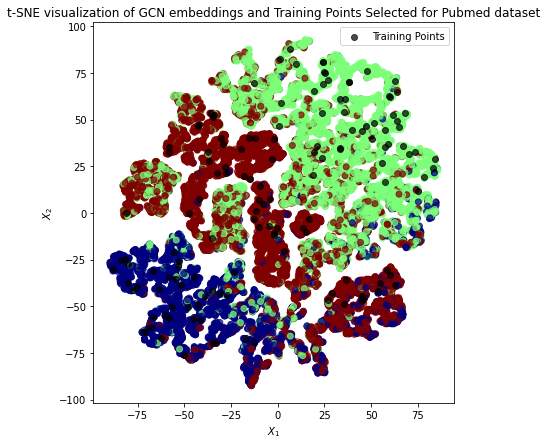

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE

X=new_features.cpu().detach().numpy()
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
fin_labels=labels.cpu().numpy()

fig, ax = plt.subplots(figsize=(7, 7))
# for i in [0,1,8,9]:
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=fin_labels,
    cmap="jet",
    alpha=0.7,
)

X_train=X_reduced[idx_train]
fin_train_labels=fin_labels[idx_train]

ax.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c='black',
    label='Training Points',
    alpha=0.7,
    
)

ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title="t-SNE visualization of GCN embeddings and Training Points Selected for Pubmed dataset",
)
plt.legend()